<a href="https://colab.research.google.com/github/solobala/FEML23/blob/master/FEML27_DZ9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание к лекции «Feature Selection» обновленное

**Цель**:

Изучить методы отбора признаков для эффективного обучения моделей машинного обучения.

**Описание задания:**

В домашнем задании нужно решить задачу классификации точек наиболее эффективно. Для этого в работе необходимо применить различные методы по отбору признаков. Отбор признаков предпочтительнее осуществлять основываясь на математическом аппарате, поэтому данные для этого задания будут сгенерированы, чтобы избежать признаков с физическим смыслом.

# 0. Установка пакетов, импорт библиотек и пользовательские функции

In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import shap
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd 
import scipy.stats 
import seaborn as sns
import matplotlib.pyplot as plt  # Библиотека для визуализации результатов


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.feature_selection import VarianceThreshold

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
import warnings
warnings.filterwarnings('ignore')

In [4]:
def get_learn(X,y,random_seed, model):
  """
  Служебная функция. выполняет:
    - разделение на Train и test
    - обучение модели
    - расчет метрик качества classification_report
    возвращает название метода удаления выбросов, 
    classification_report в виде словаря и отдельно - accuracy
    df- датафрейм, random_seed - фиксатор генератора случ.чисел, 
    method - название метода поиска выбросов, model - модель классификатора,
    flag - признак печати результатов (True/False)
  """
  num_folds = 9

  kfold = KFold(n_splits=num_folds, random_state=random_seed, shuffle=True)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
  lr = model                                  
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  a = cross_val_score(LogisticRegression(), X, y, scoring='accuracy').mean()
 
  return a

In [5]:
def make_corr(X, y, discrete_features):
  """
   Возвращает к-ты корреляции в формате Series
  """
  corr = df.corr()
  corr_scores = pd.Series(corr, name="corr Scores", index=X.columns)
  corr_scores = corr_scores.sort_values(ascending=False)
  return corr_scores

In [6]:
def make_mi_scores(X, y, discrete_features):
  """
    Взаимная информация (МИ) между двумя случайными величинами представляет собой 
    неотрицательную величину, которая измеряет зависимость между переменными. 
    Равна нулю тогда и только тогда, когда две случайные величины независимы, 
    а более высокие значения означают более высокую зависимость.

    Функция основана на непараметрических методах оценки энтропии 
    по k-ближайшим соседним расстояниям. 
    Можно использовать для выбора одномерных признаков (sci-kit learn)
  """
  mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
  mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

In [7]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# 1. Сгенерируйте данные с помощью кода:

In [8]:
a_min=0.9
num_folds = 9
for i in range(101):
  x_data_generated, y_data_generated = make_classification(scale=1, random_state=i)

  a = get_learn(x_data_generated,y_data_generated, random_seed=i, model=LogisticRegression()) # получим значение accuracy
  if a< a_min:
    a_min = a
    random_seed = i
print(f'random_seed {random_seed}, при котором достигается худшее значение accuracy  {a_min}')

random_seed 95, при котором достигается худшее значение accuracy  0.6799999999999999


In [9]:
num_folds = 9
random_seed = 95

In [10]:
x_data_generated, y_data_generated = make_classification(scale=1, random_state=random_seed)

In [11]:
x_data_generated

array([[-0.84209792,  0.02697768, -0.24841354, ..., -1.63542062,
         0.13060068,  0.63444938],
       [ 0.66535165,  0.60302189, -1.02898348, ..., -1.4021389 ,
         0.95144163, -0.69249649],
       [ 0.52830545,  1.05435374,  0.53213123, ..., -0.33430028,
        -0.21647109, -0.44128628],
       ...,
       [-0.70865144,  0.64788706,  1.69912948, ..., -1.65453069,
         0.26004706,  0.65524933],
       [ 1.14332342, -1.32448528,  3.17090687, ..., -1.46283854,
         0.67569188,  0.29706835],
       [-2.72075554,  0.94529829,  0.94419022, ..., -0.1248346 ,
        -0.36885906, -1.36109138]])

In [12]:
y_data_generated

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1])

#2. Постройте модель логистической регрессии и оцените среднюю точность. Для этого используйте следующий код:

In [13]:
dff=pd.DataFrame()
df = pd.concat([dff, pd.DataFrame(x_data_generated)], axis= 1 )
df.columns = ['X' + str(i) for i in range(1,21)]
df=pd.concat([df, pd.DataFrame(y_data_generated)], axis= 1)
df.rename(columns={0: 'target'}, inplace=True)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,target
0,-0.842098,0.026978,-0.248414,-1.220333,1.061022,0.169922,-0.302846,0.523903,0.424951,-1.106212,...,0.899829,0.928596,-1.832490,-1.039720,0.711980,-0.579146,-1.635421,0.130601,0.634449,1
1,0.665352,0.603022,-1.028983,1.123854,1.059583,-0.530589,-0.247553,-0.900613,-0.730069,1.121022,...,-0.814031,0.243489,1.113690,0.918058,-0.950302,0.579493,-1.402139,0.951442,-0.692496,1
2,0.528305,1.054354,0.532131,1.085170,0.600809,-0.665153,1.487646,1.433506,0.062550,-1.363044,...,-0.284465,1.081715,-1.196485,-0.416510,-0.638647,0.192886,-0.334300,-0.216471,-0.441286,0
3,-0.691682,2.603795,-0.955291,0.891774,-0.312127,-0.842540,0.413324,-0.062099,-1.271516,0.228464,...,-1.246774,0.314528,-0.028095,-0.910546,1.539991,-2.023488,-0.503723,-1.956023,0.183491,1
4,0.526837,0.443762,-0.693408,0.373254,-0.659503,0.009892,0.804913,-0.713489,0.488890,-1.699117,...,-1.697123,1.048211,-0.026961,-0.247816,0.860435,-0.824411,0.976546,1.159210,-0.276401,1


In [14]:
X = df.drop(columns=['target'])
y=df['target']
a_base = get_learn(X,y, random_seed=random_seed, model=LogisticRegression()) # получим базовое значение accuracy

In [15]:
df_results= pd.DataFrame(columns = ['method', 'features', 'accuracy'])
df_results.loc[len(df_results.index)] = ['baseline', X.columns.tolist(),  a_base]

In [16]:
df_results.head()

,method,features,accuracy
0,baseline,"[X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11,...",0.68


## 0. Использование SHAP

In [17]:
shap.initjs()
X = df.drop(columns=['target'])
y=df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
model = LogisticRegression()
model.fit(X_train, y_train)
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns.tolist()[i], "=", model.coef_[0][i].round(5))


Model coefficients:

X1 = -0.04566
X2 = 1.46459
X3 = -0.56929
X4 = -0.75669
X5 = -0.28046
X6 = -0.6638
X7 = -0.32569
X8 = -0.04462
X9 = -1.03063
X10 = 0.55189
X11 = -0.21784
X12 = 0.13671
X13 = 0.2641
X14 = -0.22615
X15 = -0.13641
X16 = 0.12643
X17 = -0.5449
X18 = 0.07835
X19 = -0.32198
X20 = 0.02961


In [18]:
print(f'Самые большие по модулю к-ты {X.columns.tolist()[model.coef_[0].tolist().index(model.coef_[0].max())]} и {X.columns.tolist()[model.coef_[0].tolist().index(model.coef_[0].min())]}')

Самые большие по модулю к-ты X2 и X9


In [19]:
explainer = shap.Explainer(model.predict, X)
shap_values = explainer(X)

Permutation explainer: 101it [00:18,  3.15it/s]


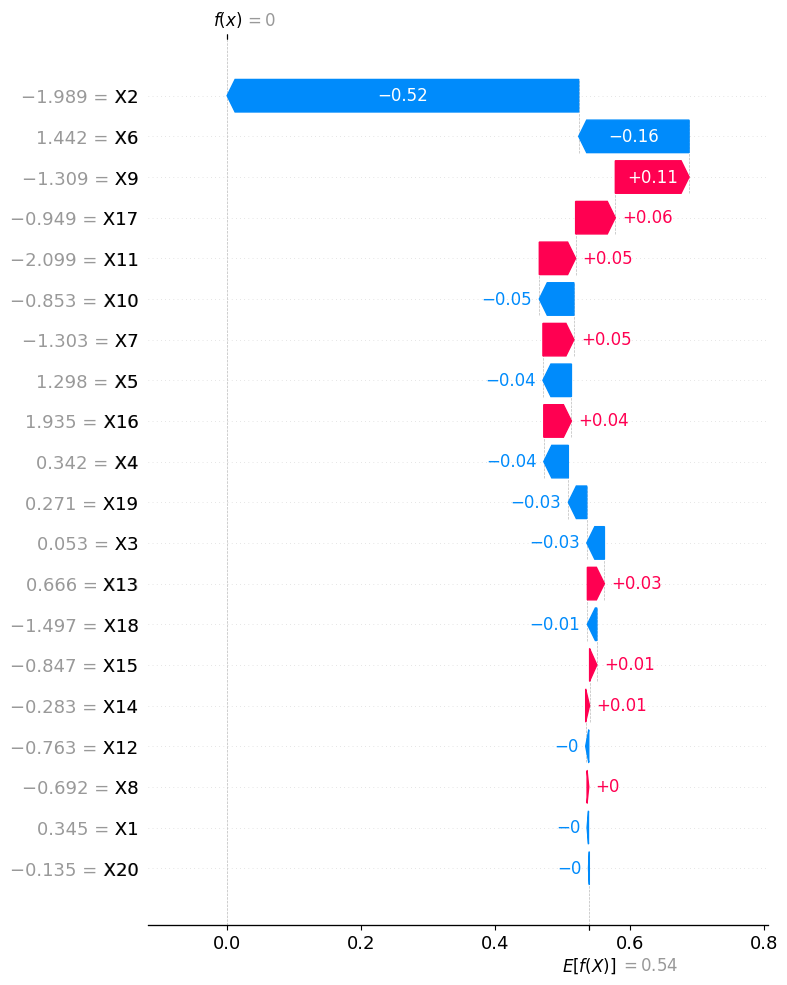

In [20]:
shap.plots.waterfall(shap_values[20], max_display=20 )

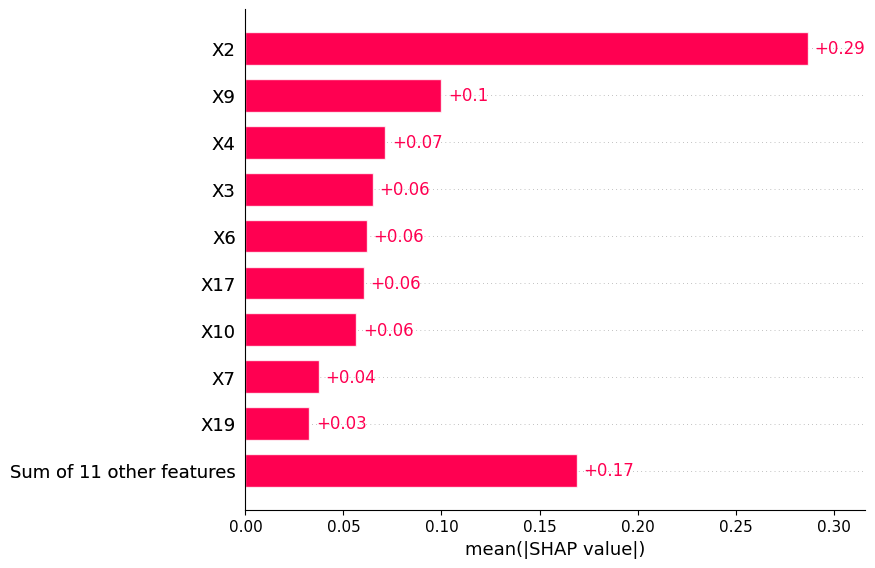

In [21]:
shap.plots.bar(shap_values)


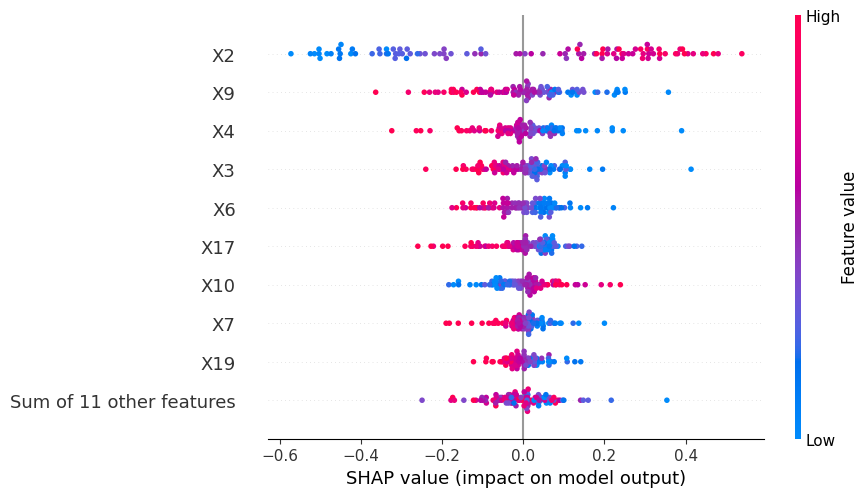

In [22]:
shap.plots.beeswarm(shap_values )

Видно, что нужно оставлять в данном датасете только X2 и X9

In [23]:
features = ['X2', 'X6']
method = 'SHAP'
X = df[features]
y=df['target']
a = get_learn(X,y, random_seed=random_seed, model=LogisticRegression())
df_results.loc[len(df_results.index)] = [method, X.columns.tolist(),  a]

In [24]:
df_results.sort_values(by='accuracy', ascending=False)

,method,features,accuracy
1,SHAP,"[X2, X6]",0.78
0,baseline,"[X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11,...",0.68


#3. Используйте статистические методы для отбора признаков:

## a) Выберите признаки на основе матрицы корреляции.

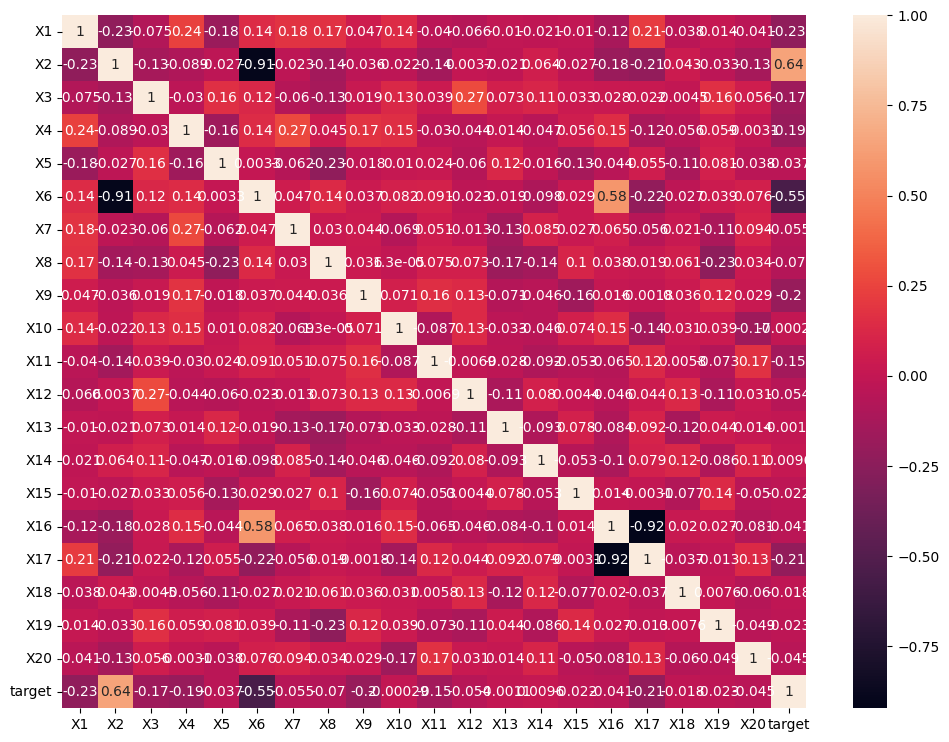

In [25]:
corr = df.corr()
plt.figure(figsize=(12,9))
sns.heatmap(corr,annot=True)
plt.show()

Отбор признаков по к-ту корреляции в данном случае - не лучшая идея (это не регррессия, а классификация).  Хотя с учетом высокой степени линейной корреляции между X2 и target,может и получиться 

In [26]:
from scipy.stats import pearsonr # В этой библиотеке не только к-т корреляции считается, но и p_value для него
a_base=0.65
thresholds = [0.2,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.9] # здесь указан порог к-та корреляции ( т.е. построена матрица, то данные взяты оттуда, а то можо было и перебором)

for thr in thresholds:
  corr_columns=[]
  method = f'corr {thr}'
  for b in X.columns.to_list():
   
    if (abs(pearsonr(X[b], y)[0])>=thr) & (abs(pearsonr(X[b], y)[1])<=0.05) & (b !='target'):
      corr_columns.append(b)
  
  features = list(set(corr_columns))
 
  if features !=[]:
    a = get_learn(df[features] ,y, random_seed=random_seed, model=LogisticRegression())  

    if a>=a_base:
      a_base = a
      a_opt = a
      features_opt = features
      method_opt = method
  
df_results.loc[len(df_results.index)] = [method_opt, features_opt,  a_opt] 


In [27]:
df_results.sort_values(by='accuracy', ascending=False)

,method,features,accuracy
1,SHAP,"[X2, X6]",0.78
2,corr 0.6,[X2],0.78
0,baseline,"[X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11,...",0.68


## b) Выбор признаков на основе Mutual Information

In [28]:
X=df.drop(columns=['target'])
y = df['target']

In [29]:
mi_scores = make_mi_scores(X,y, discrete_features='auto')
mi_scores

X2     0.251998
X6     0.148790
X13    0.117980
X16    0.081509
X4     0.031643
X12    0.026460
X3     0.016559
X8     0.013134
X1     0.012932
X9     0.011262
X15    0.000000
X19    0.000000
X18    0.000000
X17    0.000000
X11    0.000000
X14    0.000000
X10    0.000000
X7     0.000000
X5     0.000000
X20    0.000000
Name: MI Scores, dtype: float64

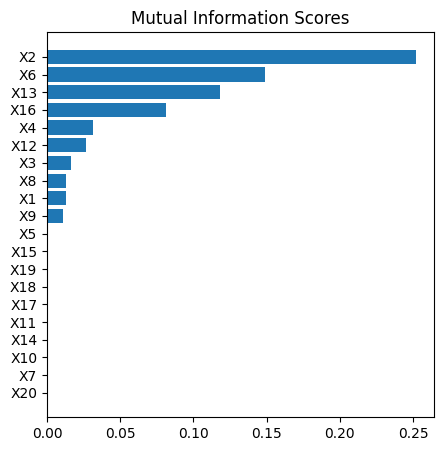

In [30]:
plt.figure(dpi=100, figsize=(5, 5))
plot_mi_scores(mi_scores)

In [31]:
features = mi_scores[mi_scores>0.01].index.tolist()
features = features[:-1]
features

['X2', 'X6', 'X13', 'X16', 'X4', 'X12', 'X3', 'X8', 'X1']

In [32]:
# Ставим порог отсечения на уровне X3=0.01
count = len(mi_scores[mi_scores>0.01])
features = mi_scores[mi_scores>0.01].index.tolist()
a_base=0.65
for i in range(count,1,-1):
  method = f'MI {i}'
  a = get_learn(df[features], y, random_seed=random_seed, model=LogisticRegression())
  # print(a, features)
  if a>=a_base:
    a_base = a
    a_opt = a
    features_opt = features
    method_opt = method
  features = features[:-1] # убираем по одному признаку до тех пор, пока метрика не начнет падать
df_results.loc[len(df_results.index)] = [method_opt, features_opt,  a_opt]  

In [33]:
df_results.sort_values(by='accuracy', ascending=False)

,method,features,accuracy
3,MI 5,"[X2, X6, X13, X16, X4]",0.80
1,SHAP,"[X2, X6]",0.78
2,corr 0.6,[X2],0.78
0,baseline,"[X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11,...",0.68


## c) Отсеките низковариативные признаки (VarianceThreshold).

## d) Повторите п. 2 на отобранных признаках в п. 3a, п. 3b.

In [34]:
X=df.drop(columns=['target'])

In [35]:
# Меняем Threshhold в диапазоне и ищем порог, при котором модель показывает лучшую accuracy
thresholds = np.arange(0.25, 1.7, 0.05)
a_base=0.68
for thr in thresholds:

  method = f'VarianceThreshold_{thr:.2f}'
  selector = VarianceThreshold(thr)
  X_var = selector.fit_transform(X)
  a = get_learn(X_var,y, random_seed=random_seed, model=LogisticRegression())
  
  
  if a >= a_base:
    a_base=a
    method_opt = method
    features_opt = selector.get_feature_names_out().tolist()
    a_opt = a
 
df_results.loc[len(df_results.index)] = [method_opt, features_opt,  a_opt]

In [36]:
df_results.sort_values(by='accuracy', ascending=False)

,method,features,accuracy
3,MI 5,"[X2, X6, X13, X16, X4]",0.80
4,VarianceThreshold_1.50,"[X2, X16]",0.79
1,SHAP,"[X2, X6]",0.78
2,corr 0.6,[X2],0.78
0,baseline,"[X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11,...",0.68


# 4. Осуществите отбор признаков на основе дисперсионного анализа:

## a) Выберите 5 лучших признаков с помощью скоринговой функции для классификации f_classif (SelectKBest(f_classif, k=5)).

In [37]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
selector = SelectKBest(f_classif, k=5)
X_new = selector.fit_transform(X, y)
method = 'SelectKBest k=5'
cols_idxs = selector.get_support(indices=True)
features = df.iloc[:,cols_idxs].columns.tolist()

## b) Повторите п. 2 на отобранных признаках.

In [38]:
a=get_learn(X_new,y, random_seed=random_seed, model=LogisticRegression())
df_results.loc[len(df_results.index)] = [method, features,  a]

In [39]:
df_results.sort_values(by='accuracy', ascending=False)

,method,features,accuracy
3,MI 5,"[X2, X6, X13, X16, X4]",0.80
5,SelectKBest k=5,"[X1, X2, X6, X9, X17]",0.80
4,VarianceThreshold_1.50,"[X2, X16]",0.79
1,SHAP,"[X2, X6]",0.78
2,corr 0.6,[X2],0.78
0,baseline,"[X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11,...",0.68


## c) Пример с использованием LDA

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train, y_train)
X_lda = lda.transform(X)
a = get_learn(X_lda,y, random_seed=random_seed, model=LogisticRegression())
method = 'LDA'
features=['трансформированные в 1 признаки']
df_results.loc[len(df_results.index)] = [method, features,  a]

In [41]:
df_results.sort_values(by='accuracy', ascending=False)

,method,features,accuracy
3,MI 5,"[X2, X6, X13, X16, X4]",0.80
5,SelectKBest k=5,"[X1, X2, X6, X9, X17]",0.80
6,LDA,[трансформированные в 1 признаки],0.80
4,VarianceThreshold_1.50,"[X2, X16]",0.79
1,SHAP,"[X2, X6]",0.78
2,corr 0.6,[X2],0.78
0,baseline,"[X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11,...",0.68


## d) Пример с использованием PCA

In [42]:
a_base=0.68
for i in range(1,21):

  pca = PCA(n_components=i, random_state=random_seed)
  pca.fit(X_train, y_train)
  X_pca = pca.transform(X)
  a = get_learn(X_pca,y, random_seed=random_seed, model=LogisticRegression())
  if a > a_base:
    a_base = a
    a_opt=a
    print(pca.explained_variance_ratio_)
    method = f'PCA n_components={i}'
    features=[f'трансформированные в {i} признаки']
df_results.loc[len(df_results.index)] = [method, features,  a_opt]


[0.14377098 0.11582567]
[0.14377098 0.11582567 0.08677197]
[0.14377098 0.11582567 0.08677197 0.0829915  0.06932057]


In [43]:
df_results.sort_values(by='accuracy', ascending=False)

,method,features,accuracy
3,MI 5,"[X2, X6, X13, X16, X4]",0.80
5,SelectKBest k=5,"[X1, X2, X6, X9, X17]",0.80
6,LDA,[трансформированные в 1 признаки],0.80
7,PCA n_components=5,[трансформированные в 5 признаки],0.79
4,VarianceThreshold_1.50,"[X2, X16]",0.79
1,SHAP,"[X2, X6]",0.78
2,corr 0.6,[X2],0.78
0,baseline,"[X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11,...",0.68


e) Пример с использованнием NCA

In [44]:
a_base=0.68
for i in range(1,21):
  nca = NeighborhoodComponentsAnalysis(n_components=i, random_state=random_seed)
  nca.fit(X_train, y_train)
  X_nca = nca.transform(X)
  a = get_learn(X_nca,y, random_seed=random_seed, model=LogisticRegression())
  if a > a_base:
    a_base = a
    a_opt = a
    # print(nca.explained_variance_ratio_)
    method = f'NCA n_components={i}'
    features=[f'трансформированные в {i} признаки']
df_results.loc[len(df_results.index)] = [method, features,  a_opt]

In [45]:
df_results.sort_values(by='accuracy', ascending=False)

,method,features,accuracy
8,NCA n_components=3,[трансформированные в 3 признаки],0.83
3,MI 5,"[X2, X6, X13, X16, X4]",0.80
5,SelectKBest k=5,"[X1, X2, X6, X9, X17]",0.80
6,LDA,[трансформированные в 1 признаки],0.80
7,PCA n_components=5,[трансформированные в 5 признаки],0.79
4,VarianceThreshold_1.50,"[X2, X16]",0.79
1,SHAP,"[X2, X6]",0.78
2,corr 0.6,[X2],0.78
0,baseline,"[X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11,...",0.68


#5.  Отбор с использованием моделей:

## a) Реализуйте отбор признаков с помощью логистической регрессии. Отобранные признаки подайте далее на вход в саму логистическую регрессию (SelectFromModel). Используйте L1 регуляризацию.

In [46]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}

lr_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=random_seed)
gs_model = GridSearchCV(estimator=lr_model, param_grid=param)
X_train_std, X_test_std, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=random_seed)
gs_model.fit(X_train_std, y_train)

model = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear', random_state=random_seed)
model.fit(X_train_std, y_train)

LogisticRegression(C=0.1, penalty='l1', random_state=95, solver='liblinear')

In [47]:
model.coef_[0]

array([0.        , 0.92184737, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [48]:
coef = model.coef_[0]
imp_features = pd.Series(X.columns)[list(coef!=0)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train = X_train[imp_features]
X_test = X_test[imp_features]

In [49]:
a = get_learn(X[['X2']],y, random_seed=random_seed, model=LogisticRegression())
method ='LR_L1_regularisation'
df_results.loc[len(df_results.index)] = [method, imp_features.tolist(), a]

In [50]:
df_results.sort_values(by='accuracy', ascending=False)

,method,features,accuracy
8,NCA n_components=3,[трансформированные в 3 признаки],0.83
3,MI 5,"[X2, X6, X13, X16, X4]",0.80
5,SelectKBest k=5,"[X1, X2, X6, X9, X17]",0.80
6,LDA,[трансформированные в 1 признаки],0.80
7,PCA n_components=5,[трансформированные в 5 признаки],0.79
4,VarianceThreshold_1.50,"[X2, X16]",0.79
1,SHAP,"[X2, X6]",0.78
2,corr 0.6,[X2],0.78
9,LR_L1_regularisation,[X2],0.78
0,baseline,"[X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11,...",0.68


In [51]:
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(estimator=LogisticRegression()).fit(X, y)
X_new = selector.transform(X)
method = 'SelectFromModel'
cols_idxs = selector.get_support(indices=True)
features = df.iloc[:,cols_idxs].columns.tolist()
features

['X2', 'X3', 'X4', 'X6', 'X9', 'X17']

In [52]:
a = get_learn(X_new,y, random_seed=random_seed, model=LogisticRegression())
df_results.loc[len(df_results.index)] = [method, features, a]


In [53]:
df_results.sort_values(by='accuracy', ascending=False)

,method,features,accuracy
8,NCA n_components=3,[трансформированные в 3 признаки],0.83
3,MI 5,"[X2, X6, X13, X16, X4]",0.80
5,SelectKBest k=5,"[X1, X2, X6, X9, X17]",0.80
6,LDA,[трансформированные в 1 признаки],0.80
10,SelectFromModel,"[X2, X3, X4, X6, X9, X17]",0.80
7,PCA n_components=5,[трансформированные в 5 признаки],0.79
4,VarianceThreshold_1.50,"[X2, X16]",0.79
1,SHAP,"[X2, X6]",0.78
2,corr 0.6,[X2],0.78
9,LR_L1_regularisation,[X2],0.78


# b) Реализуйте отбор признаков с помощью модели RandomForest и встроенного атрибута feature_impotance.

In [54]:
model = RandomForestClassifier(random_state=random_seed)
model.fit(X, y)
imps = pd.Series(model.feature_importances_, index=X.columns.to_list())
features = imps.sort_values(ascending=False).head(3).index.to_list()
features
# features = imps.sort_values(ascending=False)
# features.index.tolist()

['X2', 'X6', 'X16']

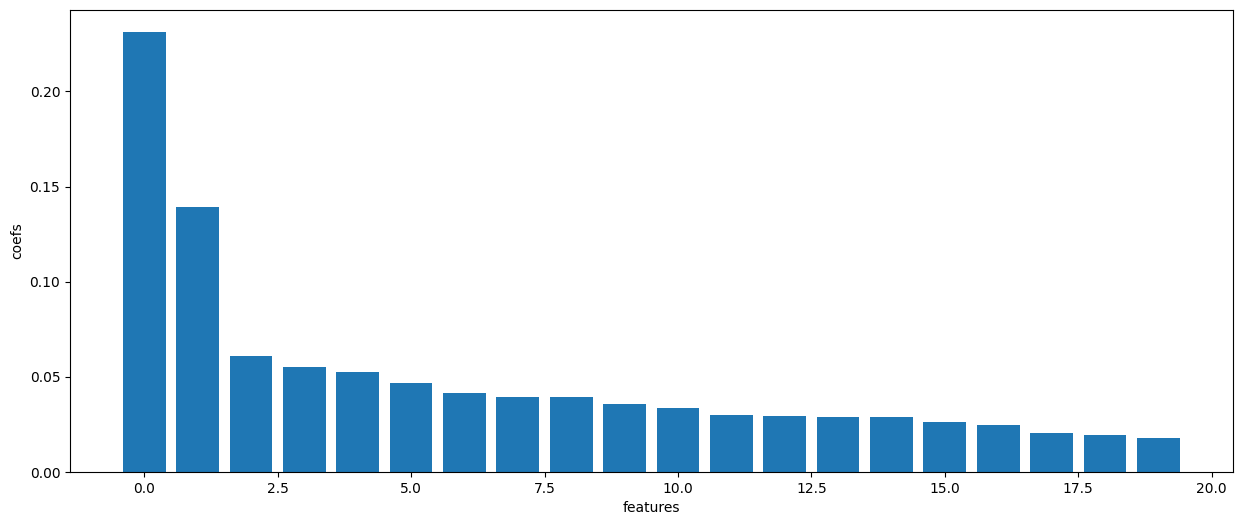

In [55]:
plt.figure(figsize=(15, 6))
plt.bar(np.arange(len(model.feature_importances_)), sorted(model.feature_importances_, reverse=True))
plt.xlabel('features')
plt.ylabel('coefs');

# c) Повторите п. 2 на отобранных признаках в п. 5a, п. 5b.

In [56]:
a = get_learn(X[features],y, random_seed=random_seed, model=RandomForestClassifier(random_state=random_seed))
method='RFC'

df_results.loc[len(df_results.index)] = [method, features,  a]

In [57]:
df_results.sort_values(by='accuracy', ascending=False)

,method,features,accuracy
8,NCA n_components=3,[трансформированные в 3 признаки],0.83
3,MI 5,"[X2, X6, X13, X16, X4]",0.80
5,SelectKBest k=5,"[X1, X2, X6, X9, X17]",0.80
6,LDA,[трансформированные в 1 признаки],0.80
10,SelectFromModel,"[X2, X3, X4, X6, X9, X17]",0.80
7,PCA n_components=5,[трансформированные в 5 признаки],0.79
4,VarianceThreshold_1.50,"[X2, X16]",0.79
11,RFC,"[X2, X6, X16]",0.79
1,SHAP,"[X2, X6]",0.78
2,corr 0.6,[X2],0.78


In [58]:
from sklearn.feature_selection import RFE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
selector = RFE(model, n_features_to_select=1, step=1)
selector = selector.fit(X_train, y_train)
selector.support_ #Это отобранные признаки
features = selector.get_feature_names_out(X.columns).tolist() # Это названия отобранных признаков


In [59]:
X_rfe=selector.transform(X)
a = cross_val_score(model, X[features], y, scoring='accuracy').mean()
method='RFC_RFE'
df_results.loc[len(df_results.index)] = [method, features,  a]


In [60]:
df_results.sort_values(by='accuracy', ascending=False)

,method,features,accuracy
8,NCA n_components=3,[трансформированные в 3 признаки],0.83
3,MI 5,"[X2, X6, X13, X16, X4]",0.80
5,SelectKBest k=5,"[X1, X2, X6, X9, X17]",0.80
6,LDA,[трансформированные в 1 признаки],0.80
10,SelectFromModel,"[X2, X3, X4, X6, X9, X17]",0.80
7,PCA n_components=5,[трансформированные в 5 признаки],0.79
4,VarianceThreshold_1.50,"[X2, X16]",0.79
11,RFC,"[X2, X6, X16]",0.79
1,SHAP,"[X2, X6]",0.78
2,corr 0.6,[X2],0.78


# 6. Перебор признаков:

## a) SequentialFeatureSelector.

In [61]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
feature_names = X.columns
sfs = SequentialFeatureSelector(knn, n_features_to_select=5, direction='backward')
sfs.fit(X, y)
features = feature_names[sfs.get_support()].tolist()
print(
    "Признаки, отобранные SequentialFeatureSelector: "
    f"{features}"
)

Признаки, отобранные SequentialFeatureSelector: ['X2', 'X5', 'X10', 'X16', 'X17']


## b) Повторите п. 2 на отобранных признаках.

In [62]:
a = get_learn(X[features] ,y, random_seed=random_seed, model=LogisticRegression())  
method='LR_SequentialFeatureSelector_backward'
df_results.loc[len(df_results.index)] = [method, features,  a]

In [63]:
df_results.sort_values(by='accuracy', ascending=False)

,method,features,accuracy
8,NCA n_components=3,[трансформированные в 3 признаки],0.83
3,MI 5,"[X2, X6, X13, X16, X4]",0.80
5,SelectKBest k=5,"[X1, X2, X6, X9, X17]",0.80
6,LDA,[трансформированные в 1 признаки],0.80
10,SelectFromModel,"[X2, X3, X4, X6, X9, X17]",0.80
7,PCA n_components=5,[трансформированные в 5 признаки],0.79
4,VarianceThreshold_1.50,"[X2, X16]",0.79
11,RFC,"[X2, X6, X16]",0.79
1,SHAP,"[X2, X6]",0.78
2,corr 0.6,[X2],0.78


# 7. Сформулируйте выводы по проделанной работе:


## a) Сделайте таблицу вида |способ выбора признаков|количество признаков|средняя точность модели|.

In [64]:
df_results.sort_values(by=['accuracy'], ascending=False).style\
         .format(precision=4, subset=['accuracy']) \
         .highlight_null(null_color='lightgrey') \
 .highlight_max(color='yellowgreen', subset=[ 'accuracy']) \
 .highlight_min(color='coral', subset=[ 'accuracy']) 

,method,features,accuracy
8,NCA n_components=3,['трансформированные в 3 признаки'],0.8300
3,MI 5,"['X2', 'X6', 'X13', 'X16', 'X4']",0.8000
5,SelectKBest k=5,"['X1', 'X2', 'X6', 'X9', 'X17']",0.8000
6,LDA,['трансформированные в 1 признаки'],0.8000
10,SelectFromModel,"['X2', 'X3', 'X4', 'X6', 'X9', 'X17']",0.8000
7,PCA n_components=5,['трансформированные в 5 признаки'],0.7900
4,VarianceThreshold_1.50,"['X2', 'X16']",0.7900
11,RFC,"['X2', 'X6', 'X16']",0.7900
1,SHAP,"['X2', 'X6']",0.7800
2,corr 0.6,['X2'],0.7800


Правильный отбор признаков может существенно повлиять на точность модели. Во всех вариантах отбора признаков фигурирует X2, и достаточно оказалось использовать только этот признак, чтобы обеспечить хорошую accuracy